System Information
---

In [1]:
!nvidia-smi

Mon Oct  5 17:42:57 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install torch==1.5.1+cu92 torchvision==0.6.1+cu92 -f https://download.pytorch.org/whl/torch_stable.html --quiet
#!pip install ipython-autotime --quiet
#%load_ext autotime

     |████████████████████████████████| 604.8MB 30kB/s 
     |████████████████████████████████| 6.5MB 72.2MB/s 


# Import packages

In [4]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML


import torch.optim as optim
import argparse
import matplotlib
import torch.nn as nn
import matplotlib.pyplot as plt

#import model_vae
from tqdm import tqdm

from torch.utils.data import DataLoader
from torchvision.utils import save_image

matplotlib.style.use('ggplot')


# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


# Dataset preparation

In [5]:
!wget https://github.com/sumankanukollu/suman_cnn/raw/master/sessions/s7_variationalAutoEncoder/dataset/processed.zip

--2020-10-05 17:45:26--  https://github.com/sumankanukollu/suman_cnn/raw/master/sessions/s7_variationalAutoEncoder/dataset/processed.zip
Resolving github.com (github.com)... 13.229.188.59
Connecting to github.com (github.com)|13.229.188.59|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/sumankanukollu/suman_cnn/master/sessions/s7_variationalAutoEncoder/dataset/processed.zip [following]
--2020-10-05 17:45:27--  https://raw.githubusercontent.com/sumankanukollu/suman_cnn/master/sessions/s7_variationalAutoEncoder/dataset/processed.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2103687 (2.0M) [application/zip]
Saving to: ‘processed.zip’

processed.zip       100%[===================>]   2.01M  --.-KB

In [6]:
import os
homepath = '/content/'
datasetZip = '/content/processed.zip'
ds = '/content/processed'
if not os.path.exists('/content/outputs_vae'):
    os.mkdir('/content/outputs_vae')

In [7]:
from zipfile import ZipFile
if not os.path.isdir(os.path.join(homepath,'processed')):
    with ZipFile(datasetZip) as z:
        z.extractall()

In [8]:
from pathlib import Path
from PIL import Image
from random import shuffle

car_images = Path(ds).glob('*/*')
car_images = list(car_images)
len(car_images)


1055

# Variables declarations

In [9]:
dataroot = ds
split_factor = 0.75

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 32

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of training epochs
num_epochs = 1

# Learning rate for optimizers
lr = 0.0001


# Data loading

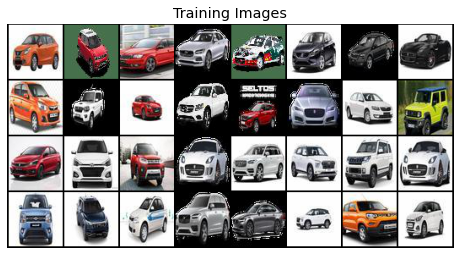

In [10]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.ToTensor(),
                            ]))


train_size = int(split_factor * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=workers)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False,num_workers=workers)


# Create the dataloader
#dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

# Plot some training images
real_batch = next(iter(val_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)));

# Mean and Std calculation

In [11]:
mean,std,nb_samples  = 0.,0.,0.
for dl in iter(train_loader):
    #i1,i2 = next(dl)
    i1,i2 = dl
    batch_samples = i1.shape[0]
    data = i1.view(i1.shape[0],i1.shape[1],-1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples
    
print(mean,std,nb_samples)
    
mean /= nb_samples
std /= nb_samples


print(mean,std)

tensor([421.7802, 416.1895, 418.0482]) tensor([236.2617, 234.8433, 234.3690]) 791.0
tensor([0.5332, 0.5262, 0.5285]) tensor([0.2987, 0.2969, 0.2963])


In [12]:
print(mean,std,nb_samples)

tensor([0.5332, 0.5262, 0.5285]) tensor([0.2987, 0.2969, 0.2963]) 791.0


In [13]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize(mean, std),
                               #transforms.Normalize((0.5344, 0.5265, 0.5280), (0.2995, 0.2994, 0.2990)),
                           ]))
# Create the dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=workers)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False,num_workers=workers)


# Define Model

In [14]:
# define a simple linear VAE
class LinearVAE(nn.Module):
    def __init__(self):
        super(LinearVAE, self).__init__()
        #self.x = x
        # Encoder 
        self.encoder = nn. Sequential(
            nn.Linear(in_features=3*64*64, out_features=512),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=512, out_features=32)
        )

        # Decoder 
        self.decoder = nn. Sequential(
            nn.Linear(in_features=32, out_features=512),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=512, out_features=3*64*64)
        )

    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample
 
    def forward(self, x):
        #print(f'### {x.shape}')
        
        # encoding
        x = self.encoder(x)

        # get `mu` and `log_var`
        mu = x
        log_var = x
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)

        # decoding
        x = self.decoder(z)
        reconstruction = torch.sigmoid(x)
        return reconstruction, mu, log_var

In [15]:
model = LinearVAE().to(device)
model.train()

LinearVAE(
  (encoder): Sequential(
    (0): Linear(in_features=12288, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=12288, bias=True)
  )
)

In [16]:
from torchsummary import summary 
from IPython.core.debugger import set_trace
#set_trace()
#summary(model, (3,64,64))

# Train model


In [17]:
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')

In [18]:
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

def fit(model, dataloader):
    model.train()
    
    running_loss = 0.0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_dataset)/dataloader.batch_size)):
        data, _ = data
        data = data.to(device)
        data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, data)
        loss = final_loss(bce_loss, mu, logvar)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss = running_loss/len(dataloader.dataset)
    return train_loss

def validate(model, dataloader):
    model.eval()
    running_loss = 0.0
    savingIndex = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_dataset)/dataloader.batch_size)):
            data, _ = data
            data = data.to(device)
            data = data.view(data.size(0), -1)
            reconstruction, mu, logvar = model(data)
            bce_loss = criterion(reconstruction, data)
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()
        
            # save the last batch input and output of every epoch
            if i == int(len(val_dataset)/dataloader.batch_size) - 1:
                num_rows = 8
                
                both = torch.cat((data.view(batch_size, 3, 64, 64)[:8], 
                                  reconstruction.view(batch_size, 3, 64, 64)[:8]))
                save_image(both.cpu(), f"/content/outputs_vae/output{epoch}.png", nrow=num_rows)
    val_loss = running_loss/len(dataloader.dataset)
    return val_loss

In [19]:
# Training Loop
num_epochs = 500

import time
# Lists to keep track of progress
train_loss = []
val_loss = []

print(f"=> Starting Training Loop for {num_epochs} epochs\n")

print_freq = 5

curr_time = time.time()
best_tloss, best_vloss =0,0
# For each epoch
for epoch in range(num_epochs):
    #print(f"\nEpoch {epoch+1} of {num_epochs}")
    train_epoch_loss = fit(model, train_loader)
    val_epoch_loss = validate(model, val_loader)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)

    if best_vloss == 0 or best_vloss > val_epoch_loss:
        print(f'### Saving best model')
        checkpoint_dir = Path('checkpoints')
        checkpoint_dir.mkdir(parents=True, exist_ok=True)
        torch.save({'model_statedict'    : model.state_dict()}, checkpoint_dir / f's7vae_bestvloss_chkpt.pth')
        best_vloss = val_epoch_loss

    # Output training stats every `print_freq` or if its end epoch
    if epoch % print_freq == 0 or epoch == num_epochs -1:
        #print(f"\n\tTrain Loss: {train_epoch_loss:.4f} \t Val Loss: {val_epoch_loss:.4f}")
        print('=> Epoch [%d/%d]\tTrain Loss: %.4f\tVal_loss: %.4f\tTime: %.5fs'
                  % (epoch, num_epochs-1, train_epoch_loss, val_epoch_loss, time.time()-curr_time))
        # start the timer again
        curr_time = time.time()



=> Starting Training Loop for 500 epochs



25it [00:00, 62.55it/s]                        
9it [00:00, 54.37it/s]                       


### Saving best model
=> Epoch [0/499]	Train Loss: 8376.7590	Val_loss: 7939.3681	Time: 0.75872s


25it [00:00, 62.61it/s]                        
9it [00:00, 65.70it/s]                       

### Saving best model



25it [00:00, 60.61it/s]                        
9it [00:00, 59.08it/s]                       


### Saving best model


25it [00:00, 67.75it/s]                        
9it [00:00, 55.65it/s]                       


### Saving best model


25it [00:00, 66.86it/s]                        
9it [00:00, 61.32it/s]                       


### Saving best model


25it [00:00, 59.06it/s]                        
9it [00:00, 63.13it/s]                       


### Saving best model
=> Epoch [5/499]	Train Loss: 6180.7170	Val_loss: 6053.8799	Time: 3.77423s


25it [00:00, 65.84it/s]                        
9it [00:00, 62.88it/s]                       


### Saving best model


25it [00:00, 63.03it/s]                        
9it [00:00, 61.52it/s]                       


### Saving best model


25it [00:00, 64.97it/s]                        
9it [00:00, 55.46it/s]                       


### Saving best model


25it [00:00, 66.46it/s]                        
9it [00:00, 62.54it/s]                       


### Saving best model


25it [00:00, 59.24it/s]                        
9it [00:00, 57.05it/s]                       


### Saving best model
=> Epoch [10/499]	Train Loss: 5844.6290	Val_loss: 5792.2482	Time: 3.75285s


25it [00:00, 66.79it/s]                        
9it [00:00, 61.51it/s]                       


### Saving best model


25it [00:00, 66.73it/s]                        
9it [00:00, 57.54it/s]                       


### Saving best model


25it [00:00, 61.03it/s]                        
9it [00:00, 61.19it/s]                       


### Saving best model


25it [00:00, 66.59it/s]                        
9it [00:00, 62.80it/s]                       


### Saving best model


25it [00:00, 66.48it/s]                        
9it [00:00, 58.51it/s]                       


### Saving best model
=> Epoch [15/499]	Train Loss: 5637.3805	Val_loss: 5608.9458	Time: 3.73101s


25it [00:00, 62.43it/s]                        
9it [00:00, 55.73it/s]                       


### Saving best model


25it [00:00, 69.30it/s]                        
9it [00:00, 60.11it/s]                       


### Saving best model


25it [00:00, 62.42it/s]                        
9it [00:00, 60.35it/s]                       
25it [00:00, 67.58it/s]
9it [00:00, 61.97it/s]                       


### Saving best model


25it [00:00, 67.86it/s]
9it [00:00, 63.62it/s]                       


### Saving best model
=> Epoch [20/499]	Train Loss: 5495.6886	Val_loss: 5520.4187	Time: 3.65223s


25it [00:00, 61.01it/s]                        
9it [00:00, 54.05it/s]                       
25it [00:00, 64.54it/s]                        
9it [00:00, 64.65it/s]                       

### Saving best model



25it [00:00, 63.57it/s]                        
9it [00:00, 62.78it/s]                       
25it [00:00, 69.85it/s]                        
9it [00:00, 56.42it/s]                       
25it [00:00, 65.04it/s]                        
9it [00:00, 58.08it/s]                       


### Saving best model
=> Epoch [25/499]	Train Loss: 5415.0670	Val_loss: 5434.8349	Time: 3.47866s


25it [00:00, 61.86it/s]                        
9it [00:00, 61.11it/s]                       


### Saving best model


25it [00:00, 60.48it/s]                        
9it [00:00, 63.04it/s]                       


### Saving best model


25it [00:00, 63.68it/s]                        
9it [00:00, 57.84it/s]                       


### Saving best model


25it [00:00, 64.73it/s]                        
9it [00:00, 54.91it/s]                       
25it [00:00, 61.55it/s]                        
9it [00:00, 57.74it/s]                       

=> Epoch [30/499]	Train Loss: 5350.3351	Val_loss: 5406.8434	Time: 3.72846s



25it [00:00, 66.83it/s]                        
9it [00:00, 52.62it/s]                       
25it [00:00, 66.57it/s]                        
9it [00:00, 58.23it/s]                       
25it [00:00, 64.80it/s]                        
9it [00:00, 62.17it/s]                       
25it [00:00, 68.80it/s]                        
9it [00:00, 58.83it/s]                       


### Saving best model


25it [00:00, 63.47it/s]                        
9it [00:00, 62.62it/s]                       


### Saving best model
=> Epoch [35/499]	Train Loss: 5299.0703	Val_loss: 5355.5900	Time: 3.38073s


25it [00:00, 54.37it/s]                        
9it [00:00, 58.98it/s]                       


### Saving best model


25it [00:00, 56.13it/s]                        
9it [00:00, 57.94it/s]                       


### Saving best model


25it [00:00, 65.72it/s]                        
9it [00:00, 60.80it/s]                       


### Saving best model


25it [00:00, 57.61it/s]                        
9it [00:00, 59.66it/s]                       


### Saving best model


25it [00:00, 62.62it/s]                        
9it [00:00, 60.01it/s]                       


### Saving best model
=> Epoch [40/499]	Train Loss: 5265.1154	Val_loss: 5330.2566	Time: 3.85627s


25it [00:00, 65.00it/s]                        
9it [00:00, 56.80it/s]                       
25it [00:00, 61.89it/s]                        
9it [00:00, 54.38it/s]                       


### Saving best model


25it [00:00, 56.96it/s]                        
9it [00:00, 62.04it/s]                       


### Saving best model


25it [00:00, 61.93it/s]                        
9it [00:00, 62.71it/s]                       
25it [00:00, 67.29it/s]                        
9it [00:00, 58.19it/s]                       

=> Epoch [45/499]	Train Loss: 5246.6570	Val_loss: 5335.9851	Time: 3.59441s



25it [00:00, 67.28it/s]                        
9it [00:00, 61.10it/s]                       
25it [00:00, 64.72it/s]                        
9it [00:00, 57.40it/s]                       


### Saving best model


25it [00:00, 66.55it/s]                        
9it [00:00, 58.01it/s]                       
25it [00:00, 65.51it/s]                        
9it [00:00, 61.44it/s]                       
25it [00:00, 65.16it/s]                        
9it [00:00, 38.57it/s]                       

### Saving best model
=> Epoch [50/499]	Train Loss: 5221.9472	Val_loss: 5286.5638	Time: 3.48443s



25it [00:00, 62.11it/s]                        
9it [00:00, 61.98it/s]                       


### Saving best model


25it [00:00, 65.60it/s]                        
9it [00:00, 58.27it/s]                       
25it [00:00, 65.38it/s]                        
9it [00:00, 60.00it/s]                       
25it [00:00, 65.26it/s]                        
9it [00:00, 59.42it/s]                       
25it [00:00, 62.70it/s]                        
9it [00:00, 58.98it/s]                       

=> Epoch [55/499]	Train Loss: 5193.5502	Val_loss: 5273.6985	Time: 3.39909s



25it [00:00, 50.68it/s]                        
9it [00:00, 54.47it/s]                       
25it [00:00, 64.67it/s]                        
9it [00:00, 57.36it/s]                       


### Saving best model


25it [00:00, 65.99it/s]                        
9it [00:00, 55.77it/s]                       
25it [00:00, 63.93it/s]                        
9it [00:00, 59.63it/s]                       


### Saving best model


25it [00:00, 64.44it/s]                        
9it [00:00, 54.88it/s]                       


### Saving best model
=> Epoch [60/499]	Train Loss: 5164.2633	Val_loss: 5242.3501	Time: 3.66101s


25it [00:00, 60.52it/s]                        
9it [00:00, 60.14it/s]                       
25it [00:00, 64.82it/s]                        
9it [00:00, 58.45it/s]                       
25it [00:00, 59.89it/s]                        
9it [00:00, 61.48it/s]                       


### Saving best model


25it [00:00, 65.54it/s]                        
9it [00:00, 58.84it/s]                       


### Saving best model


25it [00:00, 60.10it/s]                        
9it [00:00, 60.36it/s]                       

=> Epoch [65/499]	Train Loss: 5140.7441	Val_loss: 5273.1913	Time: 3.57662s



25it [00:00, 65.55it/s]                        
9it [00:00, 56.81it/s]                       


### Saving best model


25it [00:00, 61.16it/s]                        
9it [00:00, 56.83it/s]                       


### Saving best model


25it [00:00, 65.83it/s]                        
9it [00:00, 56.98it/s]                       
25it [00:00, 65.69it/s]                        
9it [00:00, 60.29it/s]                       
25it [00:00, 61.59it/s]                        
9it [00:00, 59.58it/s]                       

=> Epoch [70/499]	Train Loss: 5117.2025	Val_loss: 5217.4117	Time: 3.52381s



25it [00:00, 64.88it/s]                        
9it [00:00, 56.82it/s]                       
25it [00:00, 60.58it/s]                        
9it [00:00, 61.23it/s]                       
25it [00:00, 65.41it/s]                        
9it [00:00, 59.19it/s]                       
25it [00:00, 67.37it/s]                        
9it [00:00, 56.21it/s]                       


### Saving best model


25it [00:00, 66.55it/s]                        
9it [00:00, 60.82it/s]                       

=> Epoch [75/499]	Train Loss: 5099.2232	Val_loss: 5228.2078	Time: 3.40887s



25it [00:00, 64.37it/s]                        
9it [00:00, 55.58it/s]                       


### Saving best model


25it [00:00, 54.90it/s]                        
9it [00:00, 58.14it/s]                       
25it [00:00, 64.74it/s]                        
9it [00:00, 61.55it/s]                       
25it [00:00, 63.46it/s]                        
9it [00:00, 61.22it/s]                       
25it [00:00, 66.11it/s]                        
9it [00:00, 58.97it/s]                       

=> Epoch [80/499]	Train Loss: 5084.7500	Val_loss: 5205.4017	Time: 3.46629s



25it [00:00, 64.48it/s]                        
9it [00:00, 61.54it/s]                       
25it [00:00, 62.68it/s]                        
9it [00:00, 57.31it/s]                       
25it [00:00, 64.42it/s]                        
9it [00:00, 58.21it/s]                       


### Saving best model


25it [00:00, 64.13it/s]                        
9it [00:00, 59.14it/s]                       
25it [00:00, 67.19it/s]                        
9it [00:00, 59.25it/s]                       


### Saving best model
=> Epoch [85/499]	Train Loss: 5080.6214	Val_loss: 5171.9704	Time: 3.49828s


25it [00:00, 64.57it/s]                        
9it [00:00, 61.40it/s]                       
25it [00:00, 62.90it/s]                        
9it [00:00, 58.67it/s]                       
25it [00:00, 67.44it/s]                        
9it [00:00, 62.46it/s]                       
25it [00:00, 65.49it/s]                        
9it [00:00, 63.11it/s]                       


### Saving best model


25it [00:00, 56.39it/s]                        
9it [00:00, 60.80it/s]                       

=> Epoch [90/499]	Train Loss: 5060.0156	Val_loss: 5180.9749	Time: 3.48793s



25it [00:00, 65.61it/s]                        
9it [00:00, 60.27it/s]                       
25it [00:00, 66.00it/s]                        
9it [00:00, 61.43it/s]                       
25it [00:00, 65.43it/s]                        
9it [00:00, 56.52it/s]                       


### Saving best model


25it [00:00, 61.76it/s]                        
9it [00:00, 64.82it/s]                       


### Saving best model


25it [00:00, 53.51it/s]                        
9it [00:00, 60.45it/s]                       

=> Epoch [95/499]	Train Loss: 5052.6743	Val_loss: 5163.8178	Time: 3.50282s



25it [00:00, 67.39it/s]                        
9it [00:00, 57.34it/s]                       


### Saving best model


25it [00:00, 66.33it/s]                        
9it [00:00, 60.76it/s]                       


### Saving best model


25it [00:00, 67.01it/s]                        
9it [00:00, 57.31it/s]                       
25it [00:00, 66.88it/s]                        
9it [00:00, 60.32it/s]                       
25it [00:00, 64.24it/s]                        
9it [00:00, 57.60it/s]                       

=> Epoch [100/499]	Train Loss: 5033.7006	Val_loss: 5182.8215	Time: 3.40302s



25it [00:00, 66.27it/s]                        
9it [00:00, 56.49it/s]                       
25it [00:00, 68.25it/s]                        
9it [00:00, 60.08it/s]                       
25it [00:00, 64.26it/s]                        
9it [00:00, 59.92it/s]                       
25it [00:00, 66.11it/s]                        
9it [00:00, 62.41it/s]                       
25it [00:00, 58.38it/s]                        
9it [00:00, 58.95it/s]                       

=> Epoch [105/499]	Train Loss: 5018.6603	Val_loss: 5137.4670	Time: 3.33185s



25it [00:00, 64.11it/s]                        
9it [00:00, 60.50it/s]                       
25it [00:00, 64.61it/s]                        
9it [00:00, 58.70it/s]                       
25it [00:00, 66.30it/s]                        
9it [00:00, 57.35it/s]                       
25it [00:00, 67.26it/s]                        
9it [00:00, 57.90it/s]                       
25it [00:00, 64.53it/s]                        
9it [00:00, 61.85it/s]                       

=> Epoch [110/499]	Train Loss: 5024.1060	Val_loss: 5164.5515	Time: 3.28989s



25it [00:00, 64.15it/s]                        
9it [00:00, 59.97it/s]                       
25it [00:00, 65.30it/s]                        
9it [00:00, 58.42it/s]                       
25it [00:00, 66.84it/s]                        
9it [00:00, 61.79it/s]                       


### Saving best model


25it [00:00, 57.31it/s]                        
9it [00:00, 58.41it/s]                       
25it [00:00, 69.52it/s]                        
9it [00:00, 56.71it/s]                       

=> Epoch [115/499]	Train Loss: 4990.8232	Val_loss: 5141.2069	Time: 3.37095s



25it [00:00, 68.18it/s]                        
9it [00:00, 61.72it/s]                       
25it [00:00, 64.52it/s]                        
9it [00:00, 61.74it/s]                       
25it [00:00, 65.61it/s]                        
9it [00:00, 59.94it/s]                       
25it [00:00, 67.96it/s]                        
9it [00:00, 60.78it/s]                       
25it [00:00, 67.09it/s]                        
9it [00:00, 52.49it/s]                       


### Saving best model
=> Epoch [120/499]	Train Loss: 4988.7245	Val_loss: 5118.0964	Time: 3.33117s


25it [00:00, 66.02it/s]                        
9it [00:00, 59.55it/s]                       
25it [00:00, 64.72it/s]                        
9it [00:00, 60.87it/s]                       
25it [00:00, 63.96it/s]                        
9it [00:00, 61.08it/s]                       
25it [00:00, 64.83it/s]                        
9it [00:00, 59.93it/s]                       
25it [00:00, 67.70it/s]
9it [00:00, 64.57it/s]                       

=> Epoch [125/499]	Train Loss: 4975.2507	Val_loss: 5119.3425	Time: 3.31342s



25it [00:00, 66.65it/s]                        
9it [00:00, 58.93it/s]                       
25it [00:00, 68.26it/s]                        
9it [00:00, 57.36it/s]                       
25it [00:00, 64.93it/s]                        
9it [00:00, 61.28it/s]                       


### Saving best model


25it [00:00, 67.64it/s]                        
9it [00:00, 60.41it/s]                       
25it [00:00, 65.46it/s]                        
9it [00:00, 61.39it/s]                       

=> Epoch [130/499]	Train Loss: 4967.3304	Val_loss: 5133.3440	Time: 3.30790s



25it [00:00, 66.89it/s]                        
9it [00:00, 61.13it/s]                       
25it [00:00, 66.79it/s]                        
9it [00:00, 57.87it/s]                       
25it [00:00, 65.18it/s]                        
9it [00:00, 59.99it/s]                       


### Saving best model


25it [00:00, 61.12it/s]                        
9it [00:00, 58.31it/s]                       
25it [00:00, 67.81it/s]                        
9it [00:00, 59.38it/s]                       


### Saving best model
=> Epoch [135/499]	Train Loss: 4952.9514	Val_loss: 5105.6069	Time: 3.48576s


25it [00:00, 64.43it/s]                        
9it [00:00, 56.42it/s]                       
25it [00:00, 67.82it/s]                        
9it [00:00, 60.02it/s]                       
25it [00:00, 66.83it/s]                        
9it [00:00, 60.81it/s]                       


### Saving best model


25it [00:00, 64.64it/s]                        
9it [00:00, 60.68it/s]                       
25it [00:00, 66.72it/s]                        
9it [00:00, 59.94it/s]                       


### Saving best model
=> Epoch [140/499]	Train Loss: 4942.3215	Val_loss: 5094.6276	Time: 3.43204s


25it [00:00, 59.77it/s]                        
9it [00:00, 59.94it/s]                       


### Saving best model


25it [00:00, 64.72it/s]                        
9it [00:00, 59.69it/s]                       
25it [00:00, 64.34it/s]                        
9it [00:00, 61.58it/s]                       
25it [00:00, 66.26it/s]                        
9it [00:00, 57.99it/s]                       
25it [00:00, 66.71it/s]                        
9it [00:00, 60.29it/s]                       

=> Epoch [145/499]	Train Loss: 4944.3906	Val_loss: 5105.9351	Time: 3.43162s



25it [00:00, 65.15it/s]                        
9it [00:00, 60.37it/s]                       


### Saving best model


25it [00:00, 67.40it/s]                        
9it [00:00, 60.32it/s]                       
25it [00:00, 65.19it/s]                        
9it [00:00, 60.26it/s]                       
25it [00:00, 56.29it/s]                        
9it [00:00, 60.20it/s]                       
25it [00:00, 67.64it/s]                        
9it [00:00, 58.34it/s]                       


### Saving best model
=> Epoch [150/499]	Train Loss: 4929.6193	Val_loss: 5091.4697	Time: 3.48574s


25it [00:00, 63.08it/s]                        
9it [00:00, 58.67it/s]                       
25it [00:00, 62.09it/s]                        
9it [00:00, 59.02it/s]                       
25it [00:00, 65.13it/s]                        
9it [00:00, 59.61it/s]                       
25it [00:00, 67.25it/s]                        
9it [00:00, 63.94it/s]                       

### Saving best model



25it [00:00, 64.51it/s]                        
9it [00:00, 57.47it/s]                       

=> Epoch [155/499]	Train Loss: 4927.6306	Val_loss: 5094.7333	Time: 3.41354s



25it [00:00, 66.94it/s]                        
9it [00:00, 56.50it/s]                       
25it [00:00, 66.68it/s]                        
9it [00:00, 58.54it/s]                       
25it [00:00, 64.51it/s]                        
9it [00:00, 50.09it/s]                       
25it [00:00, 67.51it/s]
9it [00:00, 54.13it/s]                       
25it [00:00, 66.96it/s]                        
9it [00:00, 60.17it/s]                       

=> Epoch [160/499]	Train Loss: 4908.9894	Val_loss: 5084.9409	Time: 3.34069s



25it [00:00, 64.23it/s]                        
9it [00:00, 58.37it/s]                       
25it [00:00, 63.70it/s]                        
9it [00:00, 56.09it/s]                       


### Saving best model


25it [00:00, 64.30it/s]                        
9it [00:00, 63.47it/s]                       
25it [00:00, 64.23it/s]                        
9it [00:00, 60.97it/s]                       
25it [00:00, 66.98it/s]                        
9it [00:00, 61.54it/s]                       


### Saving best model
=> Epoch [165/499]	Train Loss: 4907.0647	Val_loss: 5072.0059	Time: 3.45931s


25it [00:00, 61.34it/s]                        
9it [00:00, 62.39it/s]                       
25it [00:00, 67.21it/s]                        
9it [00:00, 56.20it/s]                       
25it [00:00, 65.41it/s]                        
9it [00:00, 56.72it/s]                       
25it [00:00, 66.07it/s]                        
9it [00:00, 61.24it/s]                       
25it [00:00, 62.57it/s]                        
9it [00:00, 56.26it/s]                       


### Saving best model
=> Epoch [170/499]	Train Loss: 4901.2102	Val_loss: 5071.2502	Time: 3.46395s


25it [00:00, 65.72it/s]                        
9it [00:00, 62.09it/s]                       


### Saving best model


25it [00:00, 66.68it/s]                        
9it [00:00, 60.74it/s]                       
25it [00:00, 64.41it/s]                        
9it [00:00, 58.65it/s]                       
25it [00:00, 65.18it/s]                        
9it [00:00, 62.00it/s]                       
25it [00:00, 66.88it/s]                        
9it [00:00, 63.27it/s]                       


### Saving best model
=> Epoch [175/499]	Train Loss: 4888.5969	Val_loss: 5060.3620	Time: 3.46154s


25it [00:00, 67.09it/s]                        
9it [00:00, 53.25it/s]                       
25it [00:00, 62.24it/s]                        
9it [00:00, 59.30it/s]                       
25it [00:00, 67.10it/s]                        
9it [00:00, 58.48it/s]                       
25it [00:00, 63.70it/s]                        
9it [00:00, 62.42it/s]                       
25it [00:00, 62.56it/s]                        
9it [00:00, 59.93it/s]                       

=> Epoch [180/499]	Train Loss: 4890.3017	Val_loss: 5087.7948	Time: 3.36760s



25it [00:00, 65.54it/s]                        
9it [00:00, 57.45it/s]                       
25it [00:00, 65.78it/s]                        
9it [00:00, 61.70it/s]                       
25it [00:00, 62.87it/s]                        
9it [00:00, 58.32it/s]                       
25it [00:00, 63.37it/s]                        
9it [00:00, 56.24it/s]                       
25it [00:00, 62.97it/s]                        
9it [00:00, 62.35it/s]                       

=> Epoch [185/499]	Train Loss: 4880.4096	Val_loss: 5097.7980	Time: 3.34661s



25it [00:00, 68.04it/s]                        
9it [00:00, 57.73it/s]                       
25it [00:00, 68.41it/s]                        
9it [00:00, 61.87it/s]                       
25it [00:00, 65.33it/s]                        
9it [00:00, 60.59it/s]                       


### Saving best model


25it [00:00, 63.22it/s]                        
9it [00:00, 56.11it/s]                       
25it [00:00, 65.63it/s]                        
9it [00:00, 61.14it/s]                       

=> Epoch [190/499]	Train Loss: 4868.1280	Val_loss: 5066.1009	Time: 3.34078s



25it [00:00, 61.43it/s]                        
9it [00:00, 62.03it/s]                       
25it [00:00, 62.84it/s]                        
9it [00:00, 56.44it/s]                       
25it [00:00, 65.73it/s]                        
9it [00:00, 62.25it/s]                       
25it [00:00, 64.85it/s]                        
9it [00:00, 59.15it/s]                       
25it [00:00, 66.52it/s]                        
9it [00:00, 58.78it/s]                       

=> Epoch [195/499]	Train Loss: 4871.0687	Val_loss: 5086.9945	Time: 3.33007s



25it [00:00, 63.01it/s]                        
9it [00:00, 59.09it/s]                       
25it [00:00, 62.00it/s]                        
9it [00:00, 59.56it/s]                       
25it [00:00, 66.36it/s]                        
9it [00:00, 54.90it/s]                       
25it [00:00, 66.23it/s]                        
9it [00:00, 59.61it/s]                       


### Saving best model


25it [00:00, 61.24it/s]                        
9it [00:00, 60.68it/s]                       

=> Epoch [200/499]	Train Loss: 4856.0348	Val_loss: 5073.7567	Time: 3.44753s



25it [00:00, 64.67it/s]                        
9it [00:00, 55.91it/s]                       
25it [00:00, 65.82it/s]                        
9it [00:00, 59.70it/s]                       


### Saving best model


25it [00:00, 63.09it/s]                        
9it [00:00, 59.93it/s]                       
25it [00:00, 60.03it/s]                        
9it [00:00, 57.60it/s]                       
25it [00:00, 65.40it/s]                        
9it [00:00, 58.43it/s]                       

=> Epoch [205/499]	Train Loss: 4852.8247	Val_loss: 5061.3647	Time: 3.39983s



25it [00:00, 56.73it/s]                        
9it [00:00, 56.55it/s]                       
25it [00:00, 65.78it/s]                        
9it [00:00, 58.75it/s]                       
25it [00:00, 67.30it/s]                        
9it [00:00, 58.07it/s]                       
25it [00:00, 61.73it/s]                        
9it [00:00, 53.68it/s]                       
25it [00:00, 64.71it/s]                        
9it [00:00, 58.91it/s]                       

=> Epoch [210/499]	Train Loss: 4843.3517	Val_loss: 5067.2085	Time: 3.40670s



25it [00:00, 63.56it/s]                        
9it [00:00, 59.47it/s]                       
25it [00:00, 65.74it/s]                        
9it [00:00, 59.84it/s]                       
25it [00:00, 67.84it/s]                        
9it [00:00, 46.98it/s]                       
25it [00:00, 66.59it/s]                        
9it [00:00, 60.52it/s]                       
25it [00:00, 66.34it/s]                        
9it [00:00, 61.47it/s]                       


### Saving best model
=> Epoch [215/499]	Train Loss: 4837.2935	Val_loss: 5038.7289	Time: 3.38457s


25it [00:00, 64.11it/s]                        
9it [00:00, 58.79it/s]                       
25it [00:00, 67.96it/s]                        
9it [00:00, 60.15it/s]                       
25it [00:00, 63.67it/s]                        
9it [00:00, 56.24it/s]                       
25it [00:00, 66.23it/s]                        
9it [00:00, 59.65it/s]                       
25it [00:00, 64.47it/s]                        
9it [00:00, 60.80it/s]                       

=> Epoch [220/499]	Train Loss: 4827.3529	Val_loss: 5063.1063	Time: 3.31268s



25it [00:00, 64.20it/s]                        
9it [00:00, 58.58it/s]                       
25it [00:00, 63.47it/s]                        
9it [00:00, 61.07it/s]                       
25it [00:00, 68.10it/s]                        
9it [00:00, 60.59it/s]                       
25it [00:00, 66.55it/s]                        
9it [00:00, 58.92it/s]                       
25it [00:00, 67.87it/s]                        
9it [00:00, 61.42it/s]                       

=> Epoch [225/499]	Train Loss: 4824.3670	Val_loss: 5057.8633	Time: 3.27571s



25it [00:00, 66.24it/s]                        
9it [00:00, 63.22it/s]                       
25it [00:00, 66.67it/s]                        
9it [00:00, 59.17it/s]                       
25it [00:00, 67.52it/s]                        
9it [00:00, 61.71it/s]                       
25it [00:00, 64.65it/s]                        
9it [00:00, 58.87it/s]                       
25it [00:00, 66.50it/s]                        
9it [00:00, 58.03it/s]                       

=> Epoch [230/499]	Train Loss: 4827.9068	Val_loss: 5041.6433	Time: 3.26072s



25it [00:00, 67.40it/s]                        
9it [00:00, 57.64it/s]                       
25it [00:00, 64.60it/s]                        
9it [00:00, 63.49it/s]                       

### Saving best model



25it [00:00, 67.56it/s]                        
9it [00:00, 61.30it/s]                       
25it [00:00, 64.70it/s]                        
9it [00:00, 64.31it/s]                       
25it [00:00, 65.67it/s]                        
9it [00:00, 59.58it/s]                       

=> Epoch [235/499]	Train Loss: 4816.0773	Val_loss: 5056.6982	Time: 3.32072s



25it [00:00, 67.44it/s]                        
9it [00:00, 62.68it/s]                       
25it [00:00, 66.87it/s]                        
9it [00:00, 59.96it/s]                       
25it [00:00, 66.56it/s]                        
9it [00:00, 56.29it/s]                       
25it [00:00, 64.75it/s]                        
9it [00:00, 62.37it/s]                       
25it [00:00, 66.84it/s]                        
9it [00:00, 61.79it/s]                       

=> Epoch [240/499]	Train Loss: 4815.3590	Val_loss: 5050.5883	Time: 3.29533s



25it [00:00, 64.52it/s]                        
9it [00:00, 59.12it/s]                       
25it [00:00, 67.40it/s]                        
9it [00:00, 61.75it/s]                       
25it [00:00, 65.98it/s]                        
9it [00:00, 60.69it/s]                       
25it [00:00, 67.28it/s]                        
9it [00:00, 61.87it/s]                       
25it [00:00, 65.03it/s]                        
9it [00:00, 63.74it/s]                       


### Saving best model
=> Epoch [245/499]	Train Loss: 4809.9234	Val_loss: 5015.3538	Time: 3.33318s


25it [00:00, 64.80it/s]                        
9it [00:00, 62.74it/s]                       
25it [00:00, 68.09it/s]                        
9it [00:00, 63.44it/s]                       
25it [00:00, 66.90it/s]                        
9it [00:00, 61.13it/s]                       
25it [00:00, 65.67it/s]                        
9it [00:00, 59.68it/s]                       
25it [00:00, 66.84it/s]                        
9it [00:00, 55.78it/s]                       

=> Epoch [250/499]	Train Loss: 4801.6944	Val_loss: 5043.1060	Time: 3.26419s



25it [00:00, 68.74it/s]                        
9it [00:00, 62.04it/s]                       
25it [00:00, 65.47it/s]                        
9it [00:00, 57.70it/s]                       
25it [00:00, 65.00it/s]                        
9it [00:00, 57.32it/s]                       
25it [00:00, 66.03it/s]                        
9it [00:00, 61.27it/s]                       
25it [00:00, 64.66it/s]                        
9it [00:00, 59.03it/s]                       

=> Epoch [255/499]	Train Loss: 4793.6476	Val_loss: 5044.1476	Time: 3.27043s



25it [00:00, 66.08it/s]                        
9it [00:00, 58.44it/s]                       
25it [00:00, 68.37it/s]                        
9it [00:00, 58.37it/s]                       
25it [00:00, 68.00it/s]                        
9it [00:00, 62.78it/s]                       
25it [00:00, 67.01it/s]                        
9it [00:00, 60.11it/s]                       
25it [00:00, 63.63it/s]                        
9it [00:00, 59.56it/s]                       

=> Epoch [260/499]	Train Loss: 4788.2059	Val_loss: 5073.1345	Time: 3.25725s



25it [00:00, 63.18it/s]                        
9it [00:00, 61.17it/s]                       
25it [00:00, 65.97it/s]                        
9it [00:00, 61.41it/s]                       
25it [00:00, 65.09it/s]                        
9it [00:00, 59.00it/s]                       
25it [00:00, 68.97it/s]                        
9it [00:00, 60.60it/s]                       
25it [00:00, 66.52it/s]                        
9it [00:00, 57.54it/s]                       

=> Epoch [265/499]	Train Loss: 4783.1909	Val_loss: 5042.9916	Time: 3.27521s



25it [00:00, 66.78it/s]                        
9it [00:00, 58.14it/s]                       
25it [00:00, 67.23it/s]                        
9it [00:00, 60.45it/s]                       
25it [00:00, 64.66it/s]                        
9it [00:00, 59.30it/s]                       
25it [00:00, 65.33it/s]                        
9it [00:00, 60.93it/s]                       
25it [00:00, 66.06it/s]                        
9it [00:00, 56.94it/s]                       

=> Epoch [270/499]	Train Loss: 4787.5177	Val_loss: 5033.2275	Time: 3.29754s



25it [00:00, 65.94it/s]                        
9it [00:00, 59.77it/s]                       
25it [00:00, 65.64it/s]                        
9it [00:00, 60.94it/s]                       
25it [00:00, 63.67it/s]                        
9it [00:00, 56.88it/s]                       
25it [00:00, 64.33it/s]                        
9it [00:00, 59.83it/s]                       
25it [00:00, 67.76it/s]                        
9it [00:00, 60.90it/s]                       

=> Epoch [275/499]	Train Loss: 4785.4543	Val_loss: 5018.5180	Time: 3.30462s



25it [00:00, 67.79it/s]                        
9it [00:00, 60.11it/s]                       
25it [00:00, 67.07it/s]                        
9it [00:00, 58.48it/s]                       
25it [00:00, 66.66it/s]                        
9it [00:00, 61.22it/s]                       
25it [00:00, 65.92it/s]                        
9it [00:00, 62.05it/s]                       
25it [00:00, 64.19it/s]                        
9it [00:00, 58.58it/s]                       

=> Epoch [280/499]	Train Loss: 4774.2815	Val_loss: 5025.4816	Time: 3.27157s



25it [00:00, 66.81it/s]                        
9it [00:00, 61.25it/s]                       
25it [00:00, 66.38it/s]                        
9it [00:00, 57.79it/s]                       
25it [00:00, 65.20it/s]                        
9it [00:00, 63.69it/s]                       
25it [00:00, 68.79it/s]                        
9it [00:00, 59.96it/s]                       
25it [00:00, 66.16it/s]                        
9it [00:00, 60.10it/s]                       

=> Epoch [285/499]	Train Loss: 4765.0329	Val_loss: 5045.4012	Time: 3.25838s



25it [00:00, 66.29it/s]                        
9it [00:00, 62.27it/s]                       
25it [00:00, 65.40it/s]                        
9it [00:00, 57.89it/s]                       
25it [00:00, 67.21it/s]                        
9it [00:00, 59.32it/s]                       
25it [00:00, 65.17it/s]                        
9it [00:00, 59.71it/s]                       
25it [00:00, 65.16it/s]                        
9it [00:00, 63.37it/s]                       

=> Epoch [290/499]	Train Loss: 4762.6191	Val_loss: 5042.8881	Time: 3.29291s



25it [00:00, 68.09it/s]                        
9it [00:00, 57.12it/s]                       
25it [00:00, 64.31it/s]                        
9it [00:00, 60.53it/s]                       
25it [00:00, 64.11it/s]                        
9it [00:00, 62.06it/s]                       
25it [00:00, 66.07it/s]                        
9it [00:00, 57.52it/s]                       
25it [00:00, 68.20it/s]                        
9it [00:00, 61.67it/s]                       

=> Epoch [295/499]	Train Loss: 4757.6208	Val_loss: 5036.3573	Time: 3.26972s



25it [00:00, 64.15it/s]                        
9it [00:00, 62.12it/s]                       
25it [00:00, 66.31it/s]                        
9it [00:00, 61.79it/s]                       
25it [00:00, 66.33it/s]                        
9it [00:00, 57.20it/s]                       
25it [00:00, 65.64it/s]                        
9it [00:00, 60.78it/s]                       
25it [00:00, 64.87it/s]                        
9it [00:00, 62.58it/s]                       

=> Epoch [300/499]	Train Loss: 4756.1091	Val_loss: 5040.4349	Time: 3.27600s



25it [00:00, 66.30it/s]                        
9it [00:00, 61.11it/s]                       
25it [00:00, 66.54it/s]                        
9it [00:00, 55.74it/s]                       
25it [00:00, 64.52it/s]                        
9it [00:00, 60.32it/s]                       
25it [00:00, 66.51it/s]                        
9it [00:00, 62.80it/s]                       
25it [00:00, 66.78it/s]                        
9it [00:00, 53.31it/s]                       

=> Epoch [305/499]	Train Loss: 4764.1212	Val_loss: 5031.1092	Time: 3.28065s



25it [00:00, 64.92it/s]                        
9it [00:00, 60.58it/s]                       
25it [00:00, 67.18it/s]                        
9it [00:00, 61.15it/s]                       
25it [00:00, 67.31it/s]                        
9it [00:00, 61.08it/s]                       
25it [00:00, 64.13it/s]                        
9it [00:00, 60.77it/s]                       
25it [00:00, 68.36it/s]                        
9it [00:00, 62.31it/s]                       

=> Epoch [310/499]	Train Loss: 4747.2287	Val_loss: 5047.4012	Time: 3.24980s



25it [00:00, 66.77it/s]                        
9it [00:00, 62.06it/s]                       
25it [00:00, 66.43it/s]                        
9it [00:00, 58.50it/s]                       
25it [00:00, 65.61it/s]                        
9it [00:00, 60.60it/s]                       
25it [00:00, 65.24it/s]                        
9it [00:00, 59.81it/s]                       
25it [00:00, 65.82it/s]                        
9it [00:00, 56.27it/s]                       

=> Epoch [315/499]	Train Loss: 4750.1017	Val_loss: 5034.5294	Time: 3.27692s



25it [00:00, 67.58it/s]                        
9it [00:00, 58.23it/s]                       
25it [00:00, 63.92it/s]                        
9it [00:00, 60.77it/s]                       
25it [00:00, 66.49it/s]                        
9it [00:00, 55.97it/s]                       
25it [00:00, 64.90it/s]                        
9it [00:00, 56.44it/s]                       
25it [00:00, 66.38it/s]                        
9it [00:00, 61.81it/s]                       

=> Epoch [320/499]	Train Loss: 4741.1020	Val_loss: 5056.6244	Time: 3.28194s



25it [00:00, 64.26it/s]                        
9it [00:00, 59.85it/s]                       
25it [00:00, 63.95it/s]                        
9it [00:00, 60.33it/s]                       
25it [00:00, 66.27it/s]                        
9it [00:00, 59.65it/s]                       
25it [00:00, 67.39it/s]                        
9it [00:00, 59.61it/s]                       


### Saving best model


25it [00:00, 65.55it/s]                        
9it [00:00, 61.68it/s]                       

=> Epoch [325/499]	Train Loss: 4728.0025	Val_loss: 5033.7783	Time: 3.36242s



25it [00:00, 64.50it/s]                        
9it [00:00, 60.99it/s]                       
25it [00:00, 66.10it/s]                        
9it [00:00, 61.39it/s]                       
25it [00:00, 64.17it/s]                        
9it [00:00, 61.19it/s]                       
25it [00:00, 67.78it/s]                        
9it [00:00, 60.63it/s]                       
25it [00:00, 63.39it/s]                        
9it [00:00, 57.88it/s]                       

=> Epoch [330/499]	Train Loss: 4727.8749	Val_loss: 5046.0944	Time: 3.28820s



25it [00:00, 64.51it/s]                        
9it [00:00, 61.62it/s]                       
25it [00:00, 63.67it/s]                        
9it [00:00, 60.99it/s]                       
25it [00:00, 68.52it/s]                        
9it [00:00, 58.22it/s]                       
25it [00:00, 66.63it/s]                        
9it [00:00, 61.73it/s]                       
25it [00:00, 67.15it/s]                        
9it [00:00, 54.40it/s]                       

=> Epoch [335/499]	Train Loss: 4732.5768	Val_loss: 5027.1550	Time: 3.28564s



25it [00:00, 68.14it/s]                        
9it [00:00, 61.10it/s]                       
25it [00:00, 64.39it/s]                        
9it [00:00, 61.78it/s]                       
25it [00:00, 61.58it/s]                        
9it [00:00, 60.44it/s]                       
25it [00:00, 68.97it/s]                        
9it [00:00, 61.18it/s]                       
25it [00:00, 62.86it/s]                        
9it [00:00, 58.50it/s]                       

=> Epoch [340/499]	Train Loss: 4724.8441	Val_loss: 5067.0668	Time: 3.27760s



25it [00:00, 67.69it/s]                        
9it [00:00, 57.61it/s]                       
25it [00:00, 68.69it/s]                        
9it [00:00, 57.79it/s]                       
25it [00:00, 63.70it/s]                        
9it [00:00, 60.53it/s]                       
25it [00:00, 68.90it/s]
9it [00:00, 58.21it/s]                       
25it [00:00, 66.12it/s]                        
9it [00:00, 62.38it/s]                       

=> Epoch [345/499]	Train Loss: 4720.8165	Val_loss: 5066.8220	Time: 3.27290s



25it [00:00, 65.67it/s]                        
9it [00:00, 60.69it/s]                       
25it [00:00, 66.89it/s]                        
9it [00:00, 54.83it/s]                       
25it [00:00, 64.22it/s]                        
9it [00:00, 53.87it/s]                       
25it [00:00, 68.22it/s]                        
9it [00:00, 57.22it/s]                       
25it [00:00, 66.15it/s]                        
9it [00:00, 62.49it/s]                       

=> Epoch [350/499]	Train Loss: 4715.9745	Val_loss: 5039.5742	Time: 3.30029s



25it [00:00, 64.18it/s]                        
9it [00:00, 61.84it/s]                       
25it [00:00, 66.97it/s]                        
9it [00:00, 57.66it/s]                       
25it [00:00, 65.99it/s]                        
9it [00:00, 55.73it/s]                       
25it [00:00, 64.66it/s]                        
9it [00:00, 57.67it/s]                       
25it [00:00, 66.38it/s]                        
9it [00:00, 47.42it/s]                       

=> Epoch [355/499]	Train Loss: 4710.2957	Val_loss: 5028.7487	Time: 3.35414s



25it [00:00, 64.79it/s]                        
9it [00:00, 61.34it/s]                       
25it [00:00, 64.08it/s]                        
9it [00:00, 58.75it/s]                       
25it [00:00, 65.06it/s]                        
9it [00:00, 57.44it/s]                       
25it [00:00, 64.73it/s]                        
9it [00:00, 61.29it/s]                       
25it [00:00, 65.00it/s]                        
9it [00:00, 59.31it/s]                       

=> Epoch [360/499]	Train Loss: 4707.3026	Val_loss: 5035.8592	Time: 3.29640s



25it [00:00, 69.42it/s]                        
9it [00:00, 60.61it/s]                       
25it [00:00, 64.64it/s]                        
9it [00:00, 62.65it/s]                       
25it [00:00, 64.84it/s]                        
9it [00:00, 58.75it/s]                       
25it [00:00, 67.71it/s]                        
9it [00:00, 59.02it/s]                       
25it [00:00, 63.50it/s]                        
9it [00:00, 61.30it/s]                       

=> Epoch [365/499]	Train Loss: 4702.3813	Val_loss: 5064.2671	Time: 3.29719s



25it [00:00, 63.74it/s]                        
9it [00:00, 59.45it/s]                       
25it [00:00, 65.35it/s]                        
9it [00:00, 60.34it/s]                       
25it [00:00, 61.36it/s]                        
9it [00:00, 62.99it/s]                       
25it [00:00, 64.03it/s]                        
9it [00:00, 63.60it/s]                       
25it [00:00, 66.89it/s]                        
9it [00:00, 54.96it/s]                       

=> Epoch [370/499]	Train Loss: 4703.1789	Val_loss: 5045.8786	Time: 3.34787s



25it [00:00, 64.84it/s]                        
9it [00:00, 58.26it/s]                       
25it [00:00, 63.21it/s]                        
9it [00:00, 57.21it/s]                       
25it [00:00, 68.90it/s]                        
9it [00:00, 61.69it/s]                       
25it [00:00, 64.53it/s]                        
9it [00:00, 60.85it/s]                       
25it [00:00, 66.91it/s]                        
9it [00:00, 57.29it/s]                       

=> Epoch [375/499]	Train Loss: 4697.4486	Val_loss: 5029.4917	Time: 3.29552s



25it [00:00, 66.06it/s]                        
9it [00:00, 62.36it/s]                       
25it [00:00, 65.09it/s]                        
9it [00:00, 61.14it/s]                       
25it [00:00, 67.58it/s]                        
9it [00:00, 59.66it/s]                       
25it [00:00, 63.82it/s]                        
9it [00:00, 61.64it/s]                       
25it [00:00, 61.66it/s]                        
9it [00:00, 58.71it/s]                       

=> Epoch [380/499]	Train Loss: 4696.5047	Val_loss: 5045.2854	Time: 3.27467s



25it [00:00, 65.70it/s]                        
9it [00:00, 57.89it/s]                       
25it [00:00, 66.53it/s]                        
9it [00:00, 63.29it/s]                       
25it [00:00, 66.07it/s]                        
9it [00:00, 62.56it/s]                       
25it [00:00, 68.44it/s]                        
9it [00:00, 61.48it/s]                       
25it [00:00, 66.55it/s]                        
9it [00:00, 62.28it/s]                       

=> Epoch [385/499]	Train Loss: 4695.8622	Val_loss: 5052.0643	Time: 3.24878s



25it [00:00, 68.00it/s]                        
9it [00:00, 57.62it/s]                       
25it [00:00, 68.16it/s]                        
9it [00:00, 59.41it/s]                       
25it [00:00, 61.99it/s]                        
9it [00:00, 62.11it/s]                       
25it [00:00, 66.79it/s]                        
9it [00:00, 56.32it/s]                       
25it [00:00, 66.05it/s]                        
9it [00:00, 59.28it/s]                       

=> Epoch [390/499]	Train Loss: 4685.8484	Val_loss: 5039.4353	Time: 3.29019s



25it [00:00, 63.65it/s]                        
9it [00:00, 59.35it/s]                       
25it [00:00, 67.14it/s]                        
9it [00:00, 55.85it/s]                       
25it [00:00, 64.98it/s]                        
9it [00:00, 59.79it/s]                       
25it [00:00, 63.92it/s]                        
9it [00:00, 62.55it/s]                       
25it [00:00, 64.17it/s]                        
9it [00:00, 60.98it/s]                       

=> Epoch [395/499]	Train Loss: 4685.4090	Val_loss: 5026.6408	Time: 3.30117s



25it [00:00, 69.39it/s]                        
9it [00:00, 61.78it/s]                       
25it [00:00, 68.40it/s]                        
9it [00:00, 62.81it/s]                       
25it [00:00, 68.11it/s]                        
9it [00:00, 57.75it/s]                       
25it [00:00, 64.25it/s]                        
9it [00:00, 62.74it/s]                       
25it [00:00, 65.39it/s]                        
9it [00:00, 59.05it/s]                       

=> Epoch [400/499]	Train Loss: 4681.1536	Val_loss: 5047.1359	Time: 3.27834s



25it [00:00, 66.66it/s]                        
9it [00:00, 61.09it/s]                       
25it [00:00, 63.75it/s]                        
9it [00:00, 60.86it/s]                       
25it [00:00, 65.63it/s]                        
9it [00:00, 53.62it/s]                       
25it [00:00, 65.68it/s]                        
9it [00:00, 56.96it/s]                       
25it [00:00, 65.84it/s]                        
9it [00:00, 60.70it/s]                       

=> Epoch [405/499]	Train Loss: 4676.2339	Val_loss: 5063.3826	Time: 3.32140s



25it [00:00, 66.12it/s]                        
9it [00:00, 54.82it/s]                       
25it [00:00, 65.80it/s]                        
9it [00:00, 59.72it/s]                       
25it [00:00, 64.17it/s]                        
9it [00:00, 61.67it/s]                       
25it [00:00, 65.13it/s]                        
9it [00:00, 60.07it/s]                       
25it [00:00, 65.24it/s]                        
9it [00:00, 63.40it/s]                       

=> Epoch [410/499]	Train Loss: 4681.2826	Val_loss: 5081.5665	Time: 3.31751s



25it [00:00, 65.14it/s]                        
9it [00:00, 60.81it/s]                       
25it [00:00, 65.45it/s]                        
9it [00:00, 53.64it/s]                       
25it [00:00, 66.37it/s]                        
9it [00:00, 59.48it/s]                       
25it [00:00, 64.73it/s]                        
9it [00:00, 61.19it/s]                       
25it [00:00, 65.43it/s]                        
9it [00:00, 62.72it/s]                       

=> Epoch [415/499]	Train Loss: 4668.8525	Val_loss: 5058.4170	Time: 3.29600s



25it [00:00, 66.35it/s]                        
9it [00:00, 58.51it/s]                       
25it [00:00, 60.69it/s]                        
9it [00:00, 57.84it/s]                       
25it [00:00, 67.07it/s]                        
9it [00:00, 62.18it/s]                       
25it [00:00, 62.48it/s]                        
9it [00:00, 58.63it/s]                       
25it [00:00, 65.35it/s]                        
9it [00:00, 59.85it/s]                       

=> Epoch [420/499]	Train Loss: 4669.3205	Val_loss: 5055.0415	Time: 3.32691s



25it [00:00, 66.80it/s]                        
9it [00:00, 57.37it/s]                       
25it [00:00, 64.67it/s]                        
9it [00:00, 57.71it/s]                       
25it [00:00, 61.40it/s]                        
9it [00:00, 58.40it/s]                       
25it [00:00, 66.64it/s]                        
9it [00:00, 61.25it/s]                       
25it [00:00, 65.52it/s]                        
9it [00:00, 61.44it/s]                       

=> Epoch [425/499]	Train Loss: 4658.9102	Val_loss: 5056.8469	Time: 3.32874s



25it [00:00, 67.61it/s]                        
9it [00:00, 59.83it/s]                       
25it [00:00, 67.86it/s]                        
9it [00:00, 64.37it/s]                       
25it [00:00, 65.24it/s]                        
9it [00:00, 55.69it/s]                       
25it [00:00, 66.84it/s]                        
9it [00:00, 58.64it/s]                       
25it [00:00, 65.72it/s]                        
9it [00:00, 61.81it/s]                       

=> Epoch [430/499]	Train Loss: 4664.1117	Val_loss: 5037.4084	Time: 3.27019s



25it [00:00, 65.88it/s]                        
9it [00:00, 55.51it/s]                       
25it [00:00, 66.62it/s]                        
9it [00:00, 59.64it/s]                       
25it [00:00, 66.76it/s]                        
9it [00:00, 57.98it/s]                       
25it [00:00, 66.57it/s]                        
9it [00:00, 57.18it/s]                       
25it [00:00, 67.55it/s]                        
9it [00:00, 59.73it/s]                       

=> Epoch [435/499]	Train Loss: 4657.6238	Val_loss: 5036.1955	Time: 3.27964s



25it [00:00, 65.71it/s]                        
9it [00:00, 59.90it/s]                       
25it [00:00, 66.24it/s]                        
9it [00:00, 60.47it/s]                       
25it [00:00, 62.58it/s]                        
9it [00:00, 60.36it/s]                       
25it [00:00, 63.95it/s]                        
9it [00:00, 59.43it/s]                       
25it [00:00, 65.90it/s]                        
9it [00:00, 57.59it/s]                       

=> Epoch [440/499]	Train Loss: 4667.3759	Val_loss: 5067.0623	Time: 3.33507s



25it [00:00, 63.94it/s]                        
9it [00:00, 60.58it/s]                       
25it [00:00, 63.84it/s]                        
9it [00:00, 35.32it/s]                       
25it [00:00, 66.02it/s]                        
9it [00:00, 57.13it/s]                       
25it [00:00, 50.45it/s]                        
9it [00:00, 55.85it/s]                       
25it [00:00, 65.11it/s]                        
9it [00:00, 34.20it/s]                       

=> Epoch [445/499]	Train Loss: 4655.1346	Val_loss: 5028.1168	Time: 3.66743s



25it [00:00, 51.91it/s]                        
9it [00:00, 42.10it/s]                       
25it [00:00, 52.35it/s]                        
9it [00:00, 29.38it/s]                       
25it [00:00, 65.25it/s]                        
9it [00:00, 58.38it/s]                       
25it [00:00, 67.63it/s]                        
9it [00:00, 58.43it/s]                       
25it [00:00, 64.54it/s]                        
9it [00:00, 56.86it/s]                       

=> Epoch [450/499]	Train Loss: 4656.5141	Val_loss: 5056.4793	Time: 3.73029s



25it [00:00, 65.20it/s]                        
9it [00:00, 58.12it/s]                       
25it [00:00, 64.08it/s]                        
9it [00:00, 59.62it/s]                       
25it [00:00, 64.98it/s]                        
9it [00:00, 58.19it/s]                       
25it [00:00, 66.51it/s]                        
9it [00:00, 56.35it/s]                       
25it [00:00, 62.67it/s]                        
9it [00:00, 60.71it/s]                       

=> Epoch [455/499]	Train Loss: 4647.0474	Val_loss: 5064.0952	Time: 3.33459s



25it [00:00, 67.11it/s]                        
9it [00:00, 55.11it/s]                       
25it [00:00, 66.26it/s]                        
9it [00:00, 54.59it/s]                       
25it [00:00, 66.06it/s]                        
9it [00:00, 58.66it/s]                       
25it [00:00, 65.55it/s]                        
9it [00:00, 60.91it/s]                       
25it [00:00, 65.01it/s]                        
9it [00:00, 58.76it/s]                       

=> Epoch [460/499]	Train Loss: 4643.9018	Val_loss: 5047.8487	Time: 3.31362s



25it [00:00, 65.94it/s]                        
9it [00:00, 61.64it/s]                       
25it [00:00, 65.53it/s]                        
9it [00:00, 60.63it/s]                       
25it [00:00, 66.52it/s]                        
9it [00:00, 57.99it/s]                       
25it [00:00, 67.86it/s]                        
9it [00:00, 54.23it/s]                       
25it [00:00, 64.55it/s]                        
9it [00:00, 58.50it/s]                       

=> Epoch [465/499]	Train Loss: 4643.0590	Val_loss: 5051.6568	Time: 3.30213s



25it [00:00, 66.44it/s]                        
9it [00:00, 56.88it/s]                       
25it [00:00, 67.64it/s]                        
9it [00:00, 59.00it/s]                       
25it [00:00, 64.70it/s]                        
9it [00:00, 61.19it/s]                       
25it [00:00, 66.49it/s]                        
9it [00:00, 62.61it/s]                       
25it [00:00, 67.94it/s]                        
9it [00:00, 56.99it/s]                       

=> Epoch [470/499]	Train Loss: 4639.2174	Val_loss: 5056.8858	Time: 3.29380s



25it [00:00, 65.30it/s]                        
9it [00:00, 48.68it/s]                       
25it [00:00, 66.04it/s]                        
9it [00:00, 59.81it/s]                       
25it [00:00, 64.99it/s]                        
9it [00:00, 59.87it/s]                       
25it [00:00, 64.81it/s]                        
9it [00:00, 60.45it/s]                       
25it [00:00, 67.11it/s]                        
9it [00:00, 59.87it/s]                       

=> Epoch [475/499]	Train Loss: 4634.8843	Val_loss: 5053.7325	Time: 3.34240s



25it [00:00, 66.28it/s]                        
9it [00:00, 61.05it/s]                       
25it [00:00, 65.42it/s]                        
9it [00:00, 57.86it/s]                       
25it [00:00, 66.20it/s]                        
9it [00:00, 58.67it/s]                       
25it [00:00, 64.89it/s]                        
9it [00:00, 62.19it/s]                       
25it [00:00, 65.32it/s]                        
9it [00:00, 57.14it/s]                       

=> Epoch [480/499]	Train Loss: 4636.6837	Val_loss: 5045.3429	Time: 3.31061s



25it [00:00, 69.31it/s]                        
9it [00:00, 61.51it/s]                       
25it [00:00, 65.34it/s]                        
9it [00:00, 59.07it/s]                       
25it [00:00, 62.76it/s]                        
9it [00:00, 54.88it/s]                       
25it [00:00, 67.22it/s]                        
9it [00:00, 56.89it/s]                       
25it [00:00, 64.51it/s]                        
9it [00:00, 60.43it/s]                       

=> Epoch [485/499]	Train Loss: 4628.6731	Val_loss: 5067.6626	Time: 3.30585s



25it [00:00, 66.75it/s]                        
9it [00:00, 59.33it/s]                       
25it [00:00, 69.07it/s]                        
9it [00:00, 55.71it/s]                       
25it [00:00, 65.00it/s]                        
9it [00:00, 59.99it/s]                       
25it [00:00, 64.61it/s]                        
9it [00:00, 59.66it/s]                       
25it [00:00, 65.58it/s]                        
9it [00:00, 60.14it/s]                       

=> Epoch [490/499]	Train Loss: 4631.6013	Val_loss: 5038.7878	Time: 3.29623s



25it [00:00, 65.06it/s]                        
9it [00:00, 61.56it/s]                       
25it [00:00, 66.87it/s]                        
9it [00:00, 61.32it/s]                       
25it [00:00, 67.82it/s]                        
9it [00:00, 64.58it/s]                       
25it [00:00, 66.34it/s]                        
9it [00:00, 60.82it/s]                       
25it [00:00, 65.81it/s]                        
9it [00:00, 58.34it/s]                       

=> Epoch [495/499]	Train Loss: 4622.7153	Val_loss: 5039.0599	Time: 3.29427s



25it [00:00, 65.87it/s]                        
9it [00:00, 62.35it/s]                       
25it [00:00, 64.92it/s]                        
9it [00:00, 62.76it/s]                       
25it [00:00, 70.41it/s]
9it [00:00, 56.88it/s]                       
25it [00:00, 67.69it/s]                        
9it [00:00, 58.32it/s]                       

=> Epoch [499/499]	Train Loss: 4625.4472	Val_loss: 5057.4898	Time: 2.61095s


In [20]:
l1 = sorted(os.listdir('/content/checkpoints'))
l1

['s7vae_bestvloss_chkpt_0000.pth',
 's7vae_bestvloss_chkpt_0001.pth',
 's7vae_bestvloss_chkpt_0002.pth',
 's7vae_bestvloss_chkpt_0003.pth',
 's7vae_bestvloss_chkpt_0004.pth',
 's7vae_bestvloss_chkpt_0005.pth',
 's7vae_bestvloss_chkpt_0006.pth',
 's7vae_bestvloss_chkpt_0007.pth',
 's7vae_bestvloss_chkpt_0008.pth',
 's7vae_bestvloss_chkpt_0009.pth',
 's7vae_bestvloss_chkpt_0010.pth',
 's7vae_bestvloss_chkpt_0011.pth',
 's7vae_bestvloss_chkpt_0012.pth',
 's7vae_bestvloss_chkpt_0013.pth',
 's7vae_bestvloss_chkpt_0014.pth',
 's7vae_bestvloss_chkpt_0015.pth',
 's7vae_bestvloss_chkpt_0016.pth',
 's7vae_bestvloss_chkpt_0017.pth',
 's7vae_bestvloss_chkpt_0019.pth',
 's7vae_bestvloss_chkpt_0020.pth',
 's7vae_bestvloss_chkpt_0022.pth',
 's7vae_bestvloss_chkpt_0025.pth',
 's7vae_bestvloss_chkpt_0026.pth',
 's7vae_bestvloss_chkpt_0027.pth',
 's7vae_bestvloss_chkpt_0028.pth',
 's7vae_bestvloss_chkpt_0034.pth',
 's7vae_bestvloss_chkpt_0035.pth',
 's7vae_bestvloss_chkpt_0036.pth',
 's7vae_bestvloss_ch

In [ ]:
! ls -hl checkpoints

! zip -rq s7VAE_custom_checkpoints.zip checkpoints/

In [21]:
!cp '/content/outputs_vae/output324.png' '/content/drive/My Drive/EVA4/phase2/s7_variationalAutoEncoder'

In [22]:
!cp '/content/checkpoints/s7vae_bestvloss_chkpt_0324.pth' '/content/drive/My Drive/EVA4/phase2/s7_variationalAutoEncoder/'

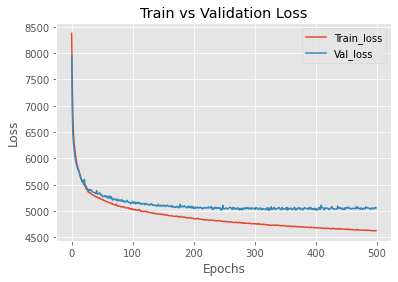

In [23]:
#train_loss
#val_loss
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_loss)
plt.plot(val_loss)

plt.title('Train vs Validation Loss')

plt.legend(['Train_loss','Val_loss']);

# Save the model and optimizers

In [24]:
checkpoint = torch.load('/content/checkpoints/s7vae_bestvloss_chkpt_0324.pth')
model.load_state_dict(checkpoint['model_statedict'])
model.eval()

LinearVAE(
  (encoder): Sequential(
    (0): Linear(in_features=12288, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=12288, bias=True)
  )
)